In [37]:
import numpy as np
import functions
import importlib
importlib.reload(functions)
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#plotting options
blue = sns.color_palette()[0]
red = sns.color_palette()[1]
green = sns.color_palette()[2]
yellow = sns.color_palette()[4]

# Seed for reproduceability
np.random.seed(1234)

In [39]:
S0 = 3e-2 # mol/L
theta = 20.0 / 60 # min
k_cat = 0.14 * 60 # 1/min
K_m = 1.5e-2 # mol/L

par = [S0, theta, k_cat, K_m]

In [40]:
S_init = 2e-2 # mol/L
E_init = 0 # mol/L

init = [S_init, E_init]

In [41]:
datasets = 1
t_max = 30
t_step = 3
t_points = 10

S, E, E0, t, t_E0 = functions.ODE_int2(datasets, t_max, t_step, t_points, par)

In [42]:
S_norm = (S - np.mean(S[:-1,:,:])) / np.std(S[:-1,:,:])
E_norm = (E - np.mean(E[:-1,:,:])) / np.std(E[:-1,:,:])
E0_norm = (E0 - np.mean(E0[:-1,:,:])) / np.std(E0[:-1,:,:])

Text(0.5, 0, 'Time [min]')

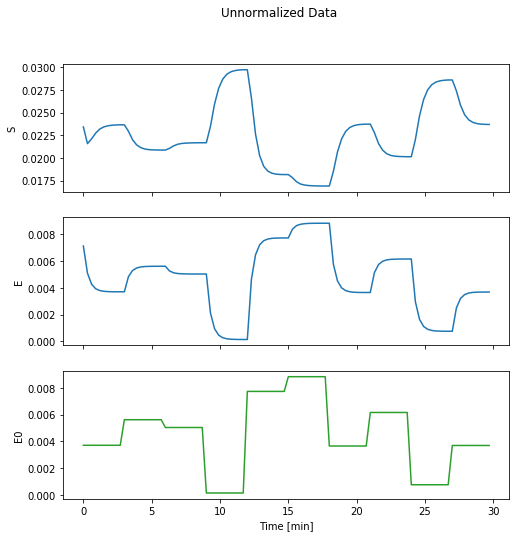

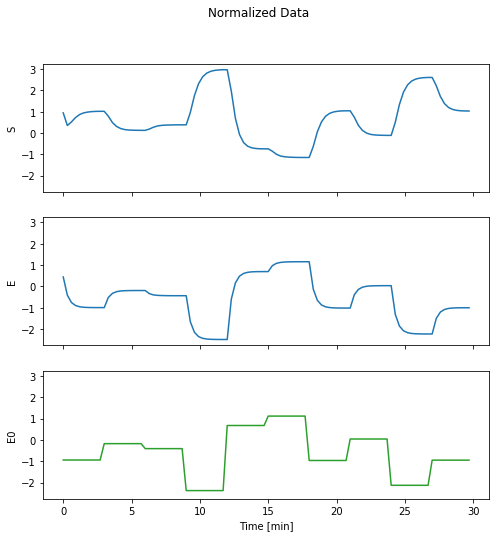

In [43]:
index = -1

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_plot = S[index,:,:].flatten()
E_plot = E[index,:,:].flatten()
E0_plot = E0[index,:,:].flatten()

S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8,8))
plt.suptitle('Unnormalized Data')
ax1.plot(t_plot, S_plot, c=blue)
ax1.set_ylabel('S')

ax2.plot(t_plot, E_plot, c=blue)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue)
ax1.set_ylabel('S')

ax2.plot(t_plot, E_norm_plot, c=blue)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_norm_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')

In [44]:
import tensorflow as tf
from tensorflow.keras import layers


HL = 3
HL_Nodes = 20
Activation = 'softplus'
learning_rate_pred = 1e-3 # default is 1e-3

model = tf.keras.Sequential()
model.add(layers.Dense(HL_Nodes, activation=Activation, input_shape=(3,)))
for i in range(HL - 1):
    model.add(layers.Dense(HL_Nodes, activation=Activation,))
model.add(layers.Dense(2, activation='linear'))

# Configure a model for mean-squared error regression.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_pred)
model.compile(optimizer=optimizer,
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 42        
Total params: 962
Trainable params: 962
Non-trainable params: 0
_________________________________________________________________


In [45]:
skip = 0

#Training
train_in = np.array([S_norm[:-1,:,skip:-1].flatten(), E_norm[:-1,:,skip:-1].flatten(), E0_norm[:-1,:,skip:-1].flatten()]).transpose()
train_pred = np.array([S_norm[:-1,:,skip+1:].flatten(), E_norm[:-1,:,skip+1:].flatten()]).transpose()
test = np.array([S_norm[-1,:,:].flatten(), E_norm[-1,:,:].flatten(), E0_norm[-1,:,:].flatten()]).transpose()

In [46]:
print(S_norm.shape)
print(S_norm[0,0,95:])
print(S_norm[0,1,:5])
print(train_in[95:105,0])
print(train_pred[95:105,0])

(2, 10, 10)
[]
[ 0.68560471  0.28090492 -0.22232477 -0.52061244 -0.67478749]
[]
[]


Training:  99%|█████████▉| 993/1000 [00:14<00:00, 58.76Epoch/s]

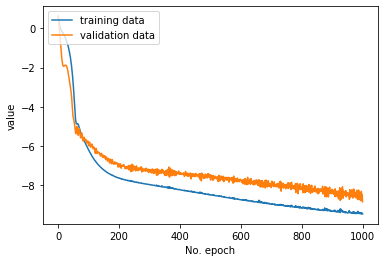

In [47]:
import kerasUtils
importlib.reload(kerasUtils)

Pbar = kerasUtils.Pbar
batch_size = 50
Epoch_Num = 1000
history = model.fit(train_in,train_pred,
                          batch_size=batch_size,
                          epochs=Epoch_Num, validation_split=0.1, verbose=False, shuffle=True, 
                          callbacks=[Pbar(Epoch_Num)]
                         )

plt.plot(np.log(history.history['loss']), label='training data')
plt.plot(np.log(history.history['val_loss']), label='validation data')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [48]:
np.shape(test)[0]
np.size(t[-1,:,:])

100

In [49]:
index = -1
test = np.array([S_norm[index,:,:].flatten(), E_norm[index,:,:].flatten(), E0_norm[index,:,:].flatten()]).transpose()

pred_offline = np.zeros(np.shape(test))
pred_offline[0,:] = test[0,:]
pred_offline[:,2] = test[:,2]

for i in range(np.shape(test)[0] - 1):
    input = pred_offline[i,:].reshape(1,3)
    output = model.predict(input)
    pred_offline[i+1,:2] = output[0,:2]
    

In [50]:
Error_Offline = np.sum((test - pred_offline) ** 2) / np.size(test)
print(Error_Offline)

0.003146775756430688


Text(0.5, 0, 'Time [min]')

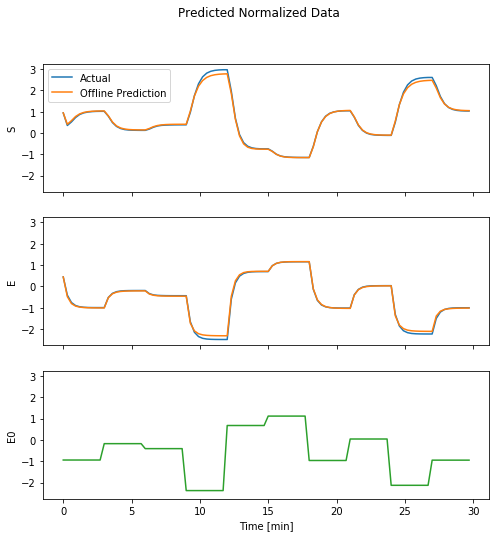

In [51]:
# index = 0

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

S_pred = pred_offline[:,0]
E_pred = pred_offline[:,1]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Predicted Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue, label='Actual')
ax1.plot(t_plot, S_pred, c=red, label='Offline Prediction')
ax1.legend()
ax1.set_ylabel('S')

ax2.plot(t_plot, E_norm_plot, c=blue)
ax2.plot(t_plot, E_pred, c=red)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_norm_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')

In [52]:
index = -1
test = np.array([S_norm[index,:,:].flatten(), E_norm[index,:,:].flatten(), E0_norm[index,:,:].flatten()]).transpose()

pred_online = np.zeros(np.shape(test))
pred_online[0,:] = test[0,:]
pred_online[:,2] = test[:,2]

for i in range(np.shape(test)[0] - 1):
    input = test[i,:].reshape(1,3)
    output = model.predict(input)
    pred_online[i+1,:2] = output[0,:2]

In [53]:
Error_Online = np.sum((test - pred_online) ** 2) / np.size(test)
print(Error_Online)

0.0010023406362090718


Text(0.5, 0, 'Time [min]')

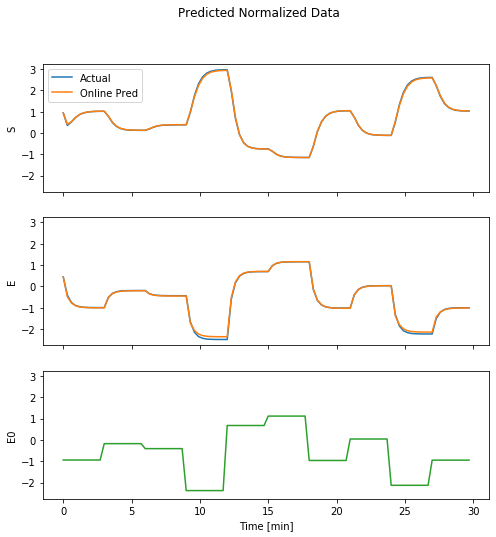

In [54]:
# index = 0

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

S_pred = pred_online[:,0]
E_pred = pred_online[:,1]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Predicted Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue, label='Actual')
ax1.plot(t_plot, S_pred, c=red, label='Online Pred')
ax1.legend()
ax1.set_ylabel('S')

ax2.plot(t_plot, E_norm_plot, c=blue)
ax2.plot(t_plot, E_pred, c=red)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_norm_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')